In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve
%matplotlib inline

# Read data

In [2]:
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')
X_train, y_train = train_data.drop('class of diagnosis', axis=1), train_data['class of diagnosis']
X_test, y_test = test_data.drop('class of diagnosis', axis=1), test_data['class of diagnosis']

continuous_names = ['age',
                        'duration of asbestos exposure',
                        'duration of symptoms', 'white blood',
                        'cell count (WBC)', 'platelet count (PLT)',
                        'sedimentation', 'blood lactic dehydrogenise (LDH)',
                        'alkaline phosphatise (ALP)', 'total protein',
                        'albumin', 'glucose', 'pleural lactic dehydrogenise',
                        'pleural protein', 'pleural albumin',
                        'pleural glucose', 'C-reactive protein (CRP)']

# Scale continuous data
Without this step, neural network works extremely poorly

In [3]:
scaler = StandardScaler()
scaler.fit(X_train[continuous_names])
scaled_cont = scaler.transform(X_train[continuous_names])

X_train_matrix = np.zeros(X_train.shape)
X_train_matrix[:, :scaled_cont.shape[1]] = scaled_cont
X_train_matrix[:, scaled_cont.shape[1]:] = X_train.drop(continuous_names, axis =1).as_matrix()

In [4]:
scaler = StandardScaler()
scaler.fit(X_test[continuous_names])
scaled_cont = scaler.transform(X_test[continuous_names])

X_test_matrix = np.zeros(X_test.shape)
X_test_matrix[:, :scaled_cont.shape[1]] = scaled_cont
X_test_matrix[:, scaled_cont.shape[1]:] = X_test.drop(continuous_names, axis =1).as_matrix()

# Test multiple hyper-parameters

In [5]:
param =[]
lista = []
means = []
for i in range(30):
    ile = np.random.randint(1, 8)
    k = []
    for i in range(ile):
        k.append(np.random.randint(30, 250))
    lista.append(tuple(k))

lista.append((252, 63, 128, 2))
lista.append((87, 69, 2, 2))
lista.append((32, 58, 2))
lista.append((193, 94, 185, 85, 166))
lista.append((106, 192, 218, 145, 88))
for el in lista:
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=el, random_state=1)
    
    scores = cross_val_score(clf, X_train_matrix, y_train, cv=5, scoring="roc_auc")
    mean_acc = scores.mean()

    param.append(el)
    means.append(mean_acc)

ind = means.index(max(means))
print("Accuracy for best model: ", means[ind])
print("Parameters for best model: ", param[ind])

Accuracy for best model:  0.692598622782
Parameters for best model:  (245,)


# Final model

In [8]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=param[ind], random_state=1)
clf.fit(X_train_matrix, y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(245,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00        50
        1.0       0.23      1.00      0.38        15

avg / total       0.05      0.23      0.09        65



/home/piotrek/miniconda3/envs/MM-diagnosis/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


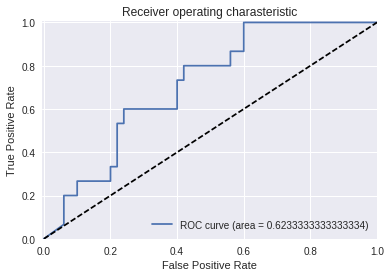

In [9]:
print(classification_report(y_test, clf.predict(X_test)))
nn_roc_auc = roc_auc_score(y_test, clf.predict(X_test_matrix))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test_matrix)[:, 1])
plt.plot(fpr, tpr, label="ROC curve (area = {})".format(nn_roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.005, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating charasteristic")
plt.legend(loc="lower right")